In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from utility import *
import datetime
from copy import deepcopy

from utility_HJo import *  # defines concatDF, dataPrep function, etc
from utility_HJo_condRNN import *  # defines functions related to condRNN

In [2]:
homedir = get_homedir(verbose=True)

C:\Users\HyeongChan Jo\OneDrive - California Institute of Technology\class\COVID-19\SKTW


In [3]:
FIPS_mapping, _ = get_FIPS()

## Demographic data

In [4]:
# retrieve berkeley dataset for demogaphical data
df_berk_orig = pd.read_csv("../data/us/aggregate_berkeley.csv")
df_berk_orig["countyFIPS"]=df_berk_orig["countyFIPS"].apply(correct_FIPS)
df_berk = fix_FIPS(df_berk_orig, fipslabel="countyFIPS")
df_berk.set_index(['countyFIPS'], inplace = True)
df_berk_orig.set_index(['countyFIPS'], inplace = True)

In [5]:
df_berk_orig.columns = df_berk_orig.columns.str.replace("'"," ")
df_berk.columns = df_berk.columns.str.replace("'"," ")

## Geolocation data

In [6]:
# retrieve geolocation data
df_geo = pd.read_csv("../data/us/geolocation/county_centers.csv")
df_geo["fips"]=df_geo["fips"].apply(correct_FIPS)
df_geo = fix_FIPS(df_geo, fipslabel="fips", reduced=True)
df_geo.set_index(['fips'], inplace = True)

In [7]:
# add population-weighted center location of each county to df_berk
df_geo_temp = df_geo[["pclon10", "pclat10"]]
df_berk2 = pd.concat([df_berk, df_geo_temp.reindex(df_berk.index)], axis = 1, sort=False, join='outer')

## GDP data

In [8]:
df_GDP = pd.read_csv("../JK/GDP.csv")
df_GDP["fips"]=df_GDP["fips"].apply(correct_FIPS)
df_GDP = fix_FIPS(df_GDP, fipslabel="fips", reduced=True)
df_GDP.set_index(['fips'], inplace = True)
# change column names
df_GDP.rename(columns={"2015": "GDP_2015", "2016": "GDP_2016", "2017": "GDP_2017", "2018": "GDP_2018"},  inplace = True)
#df_GDP.head()

df_berk2 = pd.concat([df_berk2, df_GDP.reindex(df_berk.index)], axis = 1, sort=False, join='outer')
df_berk2.columns

Index(['Unnamed: 0', 'PopulationEstimate2018', 'Population(Persons)2017',
       'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
       'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010',
       'CensusPopulation2010', 'MedianAge2010', 'MedianAge,Male2010',
       'MedianAge,Female2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', '#FTEHospitalTotal2017',
       'TotalM.D. s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
       'PopMale35-442010', 'PopFmle35-442

## Cluster data from Juhyun's work

In [9]:
path = r"\exploratory_HJo\n_clusters=5_kmeans_extended.txt"
with open(f'{homedir}'+path, 'r') as f:
    dic_cluster = eval(f.read())

## Mortality data

In [10]:
# retrieve nyt mortality data for the values to be predicted
# df_nyt = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv", index_col=[0,1])
df_nyt_orig = pd.read_csv("../data/us/covid/nyt_us_counties.csv") # , index_col=[0,3]      0: date, 3: fips
df_nyt_orig.dropna(subset = ["fips"], inplace = True)
df_nyt_orig['weekday'] = df_nyt_orig['date']
df_nyt_orig['weekday'] = pd.to_datetime(df_nyt_orig['weekday'], format = "%Y-%m-%d")
df_nyt_orig['weekday'] = df_nyt_orig['weekday'].dt.dayofweek
df_nyt_orig["fips"]=df_nyt_orig["fips"].apply(correct_FIPS)
df_nyt = fix_FIPS(df_nyt_orig, fipslabel="fips", datelabel = "date", reduced=True)

df_nyt.set_index(['date', 'fips'], inplace = True)

dateList = df_nyt.index.levels[0]
fipsList = df_nyt.index.levels[1]
print(fipsList)

# define separate df for each of the counties
df_nyt_eachCounty_accum = [df_nyt.xs(fips, level = 'fips') for fips in fipsList]
df_nyt_eachCounty = deepcopy(df_nyt_eachCounty_accum)
for i in range(len(df_nyt_eachCounty)):
    df_nyt_eachCounty[i].deaths = np.diff(np.concatenate(([0], df_nyt_eachCounty[i].loc[:, 'deaths'])) )


Index(['01001', '01003', '01005', '01007', '01009', '01011', '01013', '01015',
       '01017', '01019',
       ...
       '56025', '56027', '56029', '56031', '56033', '56035', '56037', '56039',
       '56041', '56043'],
      dtype='object', name='fips', length=2927)


In [11]:
# dataframe for converting fips into state
df_fips2state = df_nyt_orig[['state', 'fips']].copy()
df_fips2state.drop_duplicates(inplace = True)
df_fips2state.set_index('fips', inplace = True)
#print(df_fips2state.loc['02050', 'state'])

## Mobility data

In [12]:
# get neighboring county data so that we can fill the missing data in mobility dataset
df_neighbor = pd.read_csv("../data/us/geolocation/neighborcounties.csv")
df_neighbor["orgfips"]=df_neighbor["orgfips"].apply(correct_FIPS)
df_neighbor["adjfips"]=df_neighbor["adjfips"].apply(correct_FIPS)
df_neighbor.set_index(['orgfips'], inplace = True)
df_neighbor.head()

,adjfips,instate
orgfips,,
01001,01021,1
01001,01047,1
01001,01051,1
01001,01085,1
01001,01101,1


In [13]:
df_mobility_orig = pd.read_csv('../data/us/mobility/DL-us-mobility-daterow.csv')
df_mobility_orig = df_mobility_orig[~np.isnan(df_mobility_orig.fips)]
df_mobility_orig["fips"]=df_mobility_orig["fips"].apply(correct_FIPS)
df_mobility = fix_FIPS(df_mobility_orig, fipslabel="fips", datelabel = "date", reduced=True)
df_mobility.set_index(['date', 'fips'], inplace=True)

In [14]:
# retrieve mobility data. The data has been collected from from March 1st
df_mobility = pd.read_csv('../data/us/mobility/DL-us-mobility-daterow.csv')
df_mobility = df_mobility[~np.isnan(df_mobility.fips)]
df_mobility["fips"]=df_mobility["fips"].apply(correct_FIPS)
df_mobility = fix_FIPS(df_mobility, fipslabel="fips", datelabel = "date", reduced=True)
df_mobility.set_index(['date', 'fips'], inplace=True)

df_mobility_eachCounty = []
for fips in fipsList:
    try: 
        df_mobility_eachCounty.append( df_mobility.xs(fips, level = 'fips') )
    except  KeyError:
        print('fips ', fips, 'not found - using state-wise mobility data')
        state = df_fips2state.loc[fips, 'state']
        if fips == '11001':
            state = 'Washington, D.C.' # originally it's District of columnbia, which is not on mobility data
            
        df_mobility_eachCounty.append( df_mobility_orig[ (df_mobility_orig['admin_level']==1) & (df_mobility_orig['admin1']==state)] )
        df_mobility_eachCounty[-1].set_index('date', inplace=True)
        if len(df_mobility_eachCounty[-1])==0:
            print('     caution: no data for ', fips)
   


fips  02050 not found - using state-wise mobility data
fips  02150 not found - using state-wise mobility data
fips  02180 not found - using state-wise mobility data
fips  02188 not found - using state-wise mobility data
fips  02195 not found - using state-wise mobility data
fips  02201 not found - using state-wise mobility data
fips  02220 not found - using state-wise mobility data
fips  02240 not found - using state-wise mobility data
fips  02261 not found - using state-wise mobility data
fips  02290 not found - using state-wise mobility data
fips  05049 not found - using state-wise mobility data
fips  05101 not found - using state-wise mobility data
fips  06003 not found - using state-wise mobility data
fips  06105 not found - using state-wise mobility data
fips  08009 not found - using state-wise mobility data
fips  08011 not found - using state-wise mobility data
fips  08017 not found - using state-wise mobility data
fips  08021 not found - using state-wise mobility data
fips  0802

fips  31107 not found - using state-wise mobility data
fips  31123 not found - using state-wise mobility data
fips  31125 not found - using state-wise mobility data
fips  31129 not found - using state-wise mobility data
fips  31143 not found - using state-wise mobility data
fips  31161 not found - using state-wise mobility data
fips  31163 not found - using state-wise mobility data
fips  31167 not found - using state-wise mobility data
fips  31171 not found - using state-wise mobility data
fips  31175 not found - using state-wise mobility data
fips  31181 not found - using state-wise mobility data
fips  32015 not found - using state-wise mobility data
fips  32017 not found - using state-wise mobility data
fips  32021 not found - using state-wise mobility data
fips  35003 not found - using state-wise mobility data
fips  35021 not found - using state-wise mobility data
fips  35059 not found - using state-wise mobility data
fips  36041 not found - using state-wise mobility data
fips  3707

## Seasonality data

In [16]:
df_seasonality = pd.read_csv('../exploratory_HJo/seasonality_stateLevel.csv', index_col='state')
#print(df_seasonality)

## COVID Test Result data

In [17]:
df_testResult = pd.read_csv('../data/us/covid/daily_state_tests.csv')
df_testResult.set_index(['date', 'fips'], inplace=True)

df_state2fips = df_mobility_orig[ (df_mobility_orig['admin_level']==1)].copy()
df_state2fips = df_state2fips.loc[:, ['admin1', 'fips']]
df_state2fips.drop_duplicates(inplace = True)
df_state2fips.set_index('admin1', inplace = True)

df_testResult_eachCounty = []
for fips in fipsList:
    state = df_fips2state.loc[fips, 'state']
    if fips == '11001':
        state = 'Washington, D.C.' # originally it's District of columnbia, which is not on mobility data
    state_fips = int(df_state2fips.loc[state, 'fips'])

    df_testResult_eachCounty.append( df_testResult.xs(state_fips, level = 'fips') )
    #df_testResult_eachCounty[-1].sort_index(axis = 0, ascending=True, inplace=True) 
    df_testResult_eachCounty[-1] = df_testResult_eachCounty[-1].sort_index(axis = 0, ascending=True) 
    df_testResult_eachCounty[-1] = df_testResult_eachCounty[-1].fillna(0)

## function for concatenating dataframes - static values

In [18]:
def concatDF_static(data1, column1, fipsList, df_death_accum, minDeathNumber = 0, dic_cluster = []):
    # inputs
    #   data:               list of input dataframes
    #   columnName:         list of lists storing column names of input dataframes to be used
    #   fipsList:           list of fips of the counties to be used
    #   minDeathNumber:     minimum number of accumulative death on the last day that the dataset should satisfy - counties with less number of death will be removed
    
    # divide the fipslist based on the minDeathNumber
    totalNumDeath = [df_death_accum[x].iloc[-1, -1] for x in range(len(df_death_accum))]
    fipsList = [fipsList[i] for i in range(len(fipsList)) if totalNumDeath[i]>=minDeathNumber]
    
    # save the original data
    data1_orig = data1.copy()
    
    # go over each FIPS value
    dataList = []
    fips_noData = []
    fips_final = []
    for i, fips in enumerate(fipsList):
        # for data1 (demographic)
        try: 
            data1 = data1_orig.loc[fips, column1].to_numpy()
            if len(dic_cluster)!=0:
                data1 = np.append(data1, dic_cluster[fips])
        except  KeyError:
            print('fips ', fips, 'not found')
            fips_noData.append(fips)
            continue
        fips_final.append(fips)
        
        dataList.append(data1)
        
    return dataList, fips_noData, fips_final


# columns_demo = ['PopulationDensityperSqMile2010', 'PopTotalMale2017', 'PopTotalFemale2017',
#                 'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010',
#                 '#Hospitals', '#ICU_beds', 'DiabetesPercentage', 'HeartDiseaseMortality',
#                 'StrokeMortality', 'Smokers_Percentage', 'MedicareEnrollment,AgedTot2017']

columns_demo = ['PopulationEstimate2018', 'Population(Persons)2017',
       'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
       'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010',
       'CensusPopulation2010', 'MedianAge2010', 'MedianAge,Male2010',
       'MedianAge,Female2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', '#FTEHospitalTotal2017','#HospParticipatinginNetwork2017',
       'TotalM.D. s,TotNon-FedandFed2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
       'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
       'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
       'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
       'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
       'PopMale>842010', 'PopFmle>842010', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17',
       '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge45-54Years2015-17',
       '3-YrMortalityAge55-64Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17',
       'mortality2015-17Estimated', 'pclon10', 'pclat10', 'GDP_2015', 'GDP_2016', 'GDP_2017', 'GDP_2018']


## Function for concatenating dataframes - timeseries data

In [19]:
import calendar
from scipy import interpolate

def concatDF_timeseries(data2, data3, data4, data5, column2, column3, column4, column5, fipsList, df_fips2state, data_demo, fipsList_demo, date_st, date_ed, 
             df_death_accum, minDeathNumber = 0, smoothData = False, exp = 2, removeNeg = True, normalizeTarget = False):
    # inputs
    #   data:               list of input dataframes
    #   columnName:         list of lists storing column names of input dataframes to be used
    #   fipsList:           list of fips of the counties to be used
    #   fipsList_demo:      list of fips of the counties that were found in demogrpahic dataset
    #   date_st:            starting date of the dataset to be used, in datetime variable
    #   date_ed:            ending date of the dataset to be used, in datetime variable
    #   minDeathNumber:     minimum number of accumulative death on the last day that the dataset should satisfy - counties with less number of death will be removed
    #   smoothData:         whether to smooth the data with exponential filter
    #   exp:                base of the exponential filter
    #   removeNeg:          if it's true, change negative values into zeros when deaths<0
    #   normalizeTarget:    if it's true, normalize the target (deaths) too
    
    # divide the fipslist based on the minDeathNumber
    totalNumDeath = [df_death_accum[x].iloc[-1, -1] for x in range(len(df_death_accum))]
    fipsList = [fipsList[i] for i in range(len(fipsList)) if totalNumDeath[i]>=minDeathNumber]
    data2 = [data2[i] for i in range(len(fipsList)) if fipsList[i] in fipsList]

    # handle dates
    date_st_str = date_st.strftime("%Y-%m-%d")
    date_ed_str = date_ed.strftime("%Y-%m-%d")
    date_st_str_test = date_st.strftime("%Y%m%d")  # for test result dataframe
    date_ed_str_test = date_ed.strftime("%Y%m%d")  # for test result dataframe
    numDays = (date_ed-date_st).days+1
    date_st_seasonality = date_st - relativedelta(years=3)  # seasonality data has been saved based on 2017 data
    date_st_seasonality = date_st_seasonality.strftime("%Y-%m-%d")
    date_ed_seasonality = date_ed - relativedelta(years=3)
    date_ed_seasonality = date_ed_seasonality.strftime("%Y-%m-%d")
    
    # save the original data
    data2_orig = data2.copy()
    data3_orig = data3.copy()
    data4_orig = data4.copy()
    data5_orig = data5.copy()
    
    # go over each FIPS value
    dataList = []
    fips_noData = []
    fips_final = []
    for i, fips in enumerate(fipsList):
        if fips not in fipsList_demo:
            continue
        
        # for data2 (mortality)
        data2 = data2_orig[i].loc[date_st_str:date_ed_str, column2].to_numpy()
        if data2.shape[0]<numDays:
            data2 = np.concatenate( (np.zeros((numDays-data2.shape[0], len(column2))), data2), axis = 0)        
        if removeNeg: 
            data2[data2[:,1]<0, 1] = 0
        if smoothData:
            for i in range(data2.shape[0]):
                if i == 0: continue
                data2[i, 1] = data2[i, 1]+data2[i-1, 1]/exp
        
        # for data3 (mobility)
        data3 = data3_orig[i].loc[date_st_str:date_ed_str, column3].to_numpy()
        # If there are days without mobility data, copy and paste the first & last mobility data for the dates before & after the existing data
        # For the rest of the data set, use spline interpolation
        if len(data3)<numDays and len(column3)!=0:
            data3_temp = data3_orig[i].loc[date_st_str:date_ed_str, column3]
            
            # get dates on dataframe
            date = [datetime.datetime.strptime(x, "%Y-%m-%d") for x in data3_temp.index]  # given dates shown on df
            
            # figure out the first and last date on the dataset
            date_ed_temp = date[-1]  # last date in the data
            date_st_temp = date[0]   # first date in the data
            numDays_temp = (date_ed_temp - date_st_temp).days+1
            numDays_bef = (date_st_temp - datetime.datetime.combine(date_st, datetime.time(0, 0))).days  # number of dates with missing data in the beginning
            numDays_aft = (datetime.datetime.combine(date_ed, datetime.time(0, 0)) - date_ed_temp).days  # number of dates with missing data at the end
            
            # convert dates into timestamps. timestamp is for converting dates into numpy array for spline interpolation
            date_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date])
            date_mid = [date_st_temp + datetime.timedelta(days=x) for x in range(numDays_temp)]  # full list of dates from the first to the last date on a dataset
            date_mid_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date_mid])
            
            data3_mid = []
            for x, column3_each in enumerate(column3):  # go over each column specified in column3
                spl = interpolate.splrep(date_timestamp, data3[:, x], s=0)
                data3_mid.append( interpolate.splev(date_mid_timestamp, spl, der=0) )
            data3 = np.transpose(np.array(data3_mid).copy())
            
            # fill the beginning and the end of the data by copying & pasting the first & last data
            if numDays_bef!=0:
                data3_bef = np.kron( np.ones((numDays_bef,1)), data3[0, :])
                data3 = np.vstack( (data3_bef, data3) )
            if numDays_aft!=0:
                data3_aft = np.kron( np.ones((numDays_aft,1)), data3[-1, :])
                data3 = np.vstack( (data3, data3_aft) )
                    
        # for data4 (seasonality)
        state = df_fips2state.loc[fips, 'state']
        data4 = data4_orig.loc[state, :]
        data4.set_index('date', inplace=True)
        data4 = data4.loc[date_st_seasonality:date_ed_seasonality, column4]
        
        # for data5 (test result data)
        if len(column5)!=0:
            data5 = data5_orig[i].loc[date_st_str_test:date_ed_str_test, column5].to_numpy()
            # If there are days without test result data, copy and paste the first & last data for the dates before & after the existing data
            # For the rest of the data set, use spline interpolation
            if len(data5)<numDays:
                data5_temp = data5_orig[i].loc[date_st_str_test:date_ed_str_test, column5]

                # get dates on dataframe
                date = [datetime.datetime.strptime(str(x), "%Y%m%d") for x in data5_temp.index]  # given dates shown on df

                # figure out the first and last date on the dataset
                date_ed_temp = date[-1]  # last date in the data
                date_st_temp = date[0]   # first date in the data
                numDays_temp = (date_ed_temp - date_st_temp).days+1
                numDays_bef = (date_st_temp - datetime.datetime.combine(date_st, datetime.time(0, 0))).days  # number of dates with missing data in the beginning
                numDays_aft = (datetime.datetime.combine(date_ed, datetime.time(0, 0)) - date_ed_temp).days  # number of dates with missing data at the end

                # convert dates into timestamps. timestamp is for converting dates into numpy array for spline interpolation
                date_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date])
                date_mid = [date_st_temp + datetime.timedelta(days=x) for x in range(numDays_temp)]  # full list of dates from the first to the last date on a dataset
                date_mid_timestamp = np.array([calendar.timegm(x.timetuple()) for x in date_mid])

                data5_mid = []
                for x, column5_each in enumerate(column5):  # go over each column specified in column3
                    spl = interpolate.splrep(date_timestamp, data5[:, x], s=0)
                    data5_mid.append( interpolate.splev(date_mid_timestamp, spl, der=0) )
                data5 = np.transpose(np.array(data5_mid).copy())

                # fill the beginning and the end of the data by copying & pasting the first & last data
                if numDays_bef!=0:
                    data5_bef = np.kron( np.ones((numDays_bef,1)), data5[0, :])
                    data5 = np.vstack( (data5_bef, data5) )
                if numDays_aft!=0:
                    data5_aft = np.kron( np.ones((numDays_aft,1)), data5[-1, :])
                    data5 = np.vstack( (data5, data5_aft) )
                
        if len(column3)!=0:
            data = np.hstack( (data2, data3) )    
        else:
            data = data2
            
        if len(column4)!=0:
            data = np.hstack( (data, data4) )    
        
        if len(column5)!=0:
            data = np.hstack( (data, data5) )    
        
        dataList.append(data)
        
    return dataList, fips_noData, fips_final





date_st = datetime.date(2020, 3, 1)
date_ed = datetime.date(2020, 5, 21)
normalizeTarget = False

columns_mortality = ['cases', 'deaths', 'weekday']
columns_mobility = ['m50', 'm50_index']
columns_season = ['seasonality']
# columns_testResult = ['positive', 'negative', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently']
columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
       'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease'] # removed dataQualityGrade, lastUpdateEt, hash, dateChecked, as they are not numerical
    # also removed death as it's redundant


In [20]:
df_berk_withPCA = df_berk2.copy()
columns_lowCorr = ['pclon10', 'HeartDiseaseMortality', 'DiabetesPercentage','MedianAge2010', 'MedianAge,Male2010','MedianAge,Female2010',
                   'StrokeMortality', 'Smokers_Percentage', 'pclat10','FracMale2017', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010']
columns_highCorr = ['mortality2015-17Estimated', 'PopTotalFemale2017',
       '3-YrDiabetes2015-17', 
       'CensusPopulation2010', 
       '#ICU_beds', 'PopulationEstimate65+2017',
       '#FTEHospitalTotal2017', '3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '#Hospitals',
       'PopFmle>842010', 'TotalM.D. s,TotNon-FedandFed2017', 'GDP_2017',
       '#HospParticipatinginNetwork2017', 'GDP_2016', 'GDP_2015', 
       'PopFmle75-842010', 'PopMale>842010', '3-YrMortalityAge85+Years2015-17',
       '3-YrMortalityAge75-84Years2015-17',
       '3-YrMortalityAge15-24Years2015-17', 'PopFmle65-742010',
       'PopMale75-842010', '3-YrMortalityAge5-14Years2015-17',
       'PopFmle15-192010', '3-YrMortalityAge25-34Years2015-17',
       'PopMale20-242010', 'PopFmle20-242010',
       'MedicareEnrollment,AgedTot2017', 'PopMale25-292010',
       'PopFmle30-342010', '3-YrMortalityAge65-74Years2015-17',
       'PopFmle25-292010', '3-YrMortalityAge55-64Years2015-17',
       'PopFmle<52010', 'PopMale30-342010', 'PopMale<52010',
       '3-YrMortalityAge45-54Years2015-17', 'PopMale5-92010',
       'PopMale35-442010',
       '3-YrMortalityAge35-44Years2015-17', 'PopFmle5-92010',
       'PopMale10-142010', 'PopFmle10-142010', 'PopMale15-192010',
       'PopFmle60-642010', '#EligibleforMedicare2018',
       'PopMale65-742010', 'Population(Persons)2017', 
       'PopulationEstimate2018', 'PopFmle35-442010',
       'PopTotalMale2017', 
       'PopMale45-542010', 'PopFmle55-592010', 'PopMale60-642010',
       'PopFmle45-542010', 'PopMale55-592010']

df_berk_befPCA = df_berk_withPCA[columns_highCorr]
df_berk_withPCA = df_berk_withPCA[columns_lowCorr]

## Run PCA

In [22]:
# run PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# df_berk_befPCA_np = df_berk_befPCA.to_numpy()
# df_berk_befPCA_np.shape
df_berk_befPCA = StandardScaler().fit_transform(df_berk_befPCA)
pca = PCA(.999)
pc = pca.fit_transform(df_berk_befPCA)

In [23]:
print(pc.shape)
test = pd.DataFrame(pc)
test.index = df_berk_withPCA.index
test.columns = ['pc%d' % (x) for x in range(0,18)]
test.head()
#pc.shape
#dataList_static, fips_noData_static, fips_final_static = concatDF_static(df_berk2, columns_demo, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])

#df_berk_withPCA = pd.concat([df_berk_withPCA, pd.DataFrame(pc)], axis=1)
#df_berk_withPCA.join(pd.DataFrame(pc))
df_berk_withPCA = pd.concat([df_berk_withPCA, test], axis=1)
df_berk_withPCA.head()

(3113, 18)


,pclon10,HeartDiseaseMortality,DiabetesPercentage,MedianAge2010,"MedianAge,Male2010","MedianAge,Female2010",StrokeMortality,Smokers_Percentage,pclat10,FracMale2017,...,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17
countyFIPS,,,,,,,,,,,,,,,,,,,,,
01001,-86.494165,204.5,9.9,37.0,35.9,37.9,56.1,18.081557,32.500389,0.486578,...,-0.051440,0.046641,0.037642,0.130746,0.031407,0.090717,0.004226,-0.025012,0.065763,-0.054134
01003,-87.762381,183.2,8.5,41.1,40.1,42.2,41.9,17.489033,30.548923,0.485472,...,0.242081,-0.149226,-0.163714,0.288925,0.169704,-0.336700,0.068208,-0.018095,-0.136203,0.121896
01005,-85.310038,220.4,15.7,39.0,37.2,41.6,49.0,21.999985,31.844036,0.527701,...,0.038018,-0.038875,-0.021113,0.014349,0.064904,-0.010696,0.010003,-0.070605,-0.033789,0.049312
01007,-87.127659,225.5,13.3,37.8,36.5,39.5,57.2,19.114200,33.030921,0.535469,...,0.024051,-0.072956,0.004493,0.032162,0.053402,0.005343,0.000336,-0.053591,-0.027796,0.044010
01009,-86.591491,224.8,14.9,39.0,38.0,40.0,52.8,19.208672,33.955243,0.493114,...,-0.034623,0.010812,-0.045204,0.047260,0.136343,0.050106,0.166609,0.087799,0.090388,0.156895


In [24]:
pcaList = ['pc%d' % (x) for x in range(0,18)]
columns_aftPCA = columns_lowCorr + pcaList
print(columns_aftPCA)

['pclon10', 'HeartDiseaseMortality', 'DiabetesPercentage', 'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010', 'StrokeMortality', 'Smokers_Percentage', 'pclat10', 'FracMale2017', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010', 'pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17']


## select features

In [43]:
columns_aftPCA_chosen = ['pc0']
dataList_static_PCA, fips_noData_static_PCA, fips_final_static_PCA = concatDF_static(
    df_berk_withPCA, columns_aftPCA_chosen, fipsList, df_nyt_eachCounty_accum, minDeathNumber=0, dic_cluster=[])

fips  02050 not found
fips  02090 not found
fips  02110 not found
fips  02122 not found
fips  02130 not found
fips  02150 not found
fips  02170 not found
fips  02180 not found
fips  02188 not found
fips  02195 not found
fips  02201 not found
fips  02220 not found
fips  02240 not found
fips  02261 not found
fips  02290 not found
fips  08014 not found
fips  46102 not found


In [45]:
columns_time_selected = ['cases', 'deaths', 'weekday', 'positive', 'hospitalizedCumulative', 'recovered', 'hospitalized', 
                         'deathIncrease', 'positiveIncrease', 'totalTestResultsIncrease']

# choose features from time-series data
columns_mortality = ['cases', 'deaths', 'weekday']
columns_mobility = ['m50', 'm50_index']
columns_season = ['seasonality']
columns_testResult = ['positive', 'negative', 'pending', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 
       'hospitalized', 'total', 'totalTestResults', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease'] 
columns_mortality_tmp = [ x for x in columns_mortality if x in columns_time_selected]
columns_mortality_tmp = columns_mortality_tmp + ['weekday']
columns_mobility_tmp = [ x for x in columns_mobility if x in columns_time_selected]
columns_season_tmp = [ x for x in columns_season if x in columns_time_selected]
columns_testResult_tmp = [ x for x in columns_testResult if x in columns_time_selected]
columns_time_selected_reorder = columns_mortality_tmp+columns_mobility_tmp+columns_season_tmp+columns_testResult_tmp
dataList_time, fips_noData_time, fips_final_time = concatDF_timeseries(df_nyt_eachCounty, df_mobility_eachCounty, df_seasonality, df_testResult_eachCounty,
                                                         columns_mortality_tmp, columns_mobility_tmp, columns_season_tmp, columns_testResult_tmp,
                                                         fipsList, df_fips2state, df_berk2, fips_final_static_PCA, date_st, date_ed, df_nyt_eachCounty_accum, 0)
print(columns_time_selected_reorder)

['cases', 'deaths', 'weekday', 'weekday', 'positive', 'hospitalizedCumulative', 'recovered', 'hospitalized', 'deathIncrease', 'positiveIncrease', 'totalTestResultsIncrease']


In [44]:
dataList_static_PCA[0].shape
#len(dataList_static_PCA)

(1,)

## Train the model

In [47]:
inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 256
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList = []


# normalization - static
data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

# normalization - time
data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

# for static dataset
trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

# for timeseries dataset
trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

# unnormalize the targets
if not normalizeTarget:
    trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')



    
# train the model
for rep in range(num_repeat):
    model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
    model.call([trainingData_time, trainingData_static])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
              validation_data=([testingData_time, testingData_static], testingAns_time),
              epochs=num_epoch, shuffle=True, batch_size=64)
    modelList.append(model)
    historyList.append(history)
            

Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 24s 176us/sample - loss: 0.1240 - val_loss: 0.1573
Epoch 2/25
136770/136770 [==============================] - 23s 172us/sample - loss: 0.1122 - val_loss: 0.1679
Epoch 3/25
136770/136770 [==============================] - 24s 172us/sample - loss: 0.1083 - val_loss: 0.1448
Epoch 4/25
136770/136770 [==============================] - 23s 170us/sample - loss: 0.1054 - val_loss: 0.1488
Epoch 5/25
136770/136770 [==============================] - 23s 171us/sample - loss: 0.1035 - val_loss: 0.1438
Epoch 6/25
136770/136770 [==============================] - 24s 176us/sample - loss: 0.1017 - val_loss: 0.1500
Epoch 7/25
136770/136770 [==============================] - 23s 171us/sample - loss: 0.1004 - val_loss: 0.1486
Epoch 8/25
136770/136770 [==============================] - 23s 171us/sample - loss: 0.0994 - val_loss: 0.1481
Epoch 9/25
136770/136770 [==============================] - 24

In [48]:
inputSize = 7
normalizeTarget = False

quantile = 0.5
num_epoch = 25

NUM_CELLS = 512
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList512 = []


# normalization - static
data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

# normalization - time
data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

# for static dataset
trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

# for timeseries dataset
trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

# unnormalize the targets
if not normalizeTarget:
    trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')



    
# train the model
for rep in range(num_repeat):
    model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
    model.call([trainingData_time, trainingData_static])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
              validation_data=([testingData_time, testingData_static], testingAns_time),
              epochs=num_epoch, shuffle=True, batch_size=64)
    modelList.append(model)
    historyList512.append(history)
            

Train on 136770 samples, validate on 2910 samples
Epoch 1/25
136770/136770 [==============================] - 82s 600us/sample - loss: 0.1223 - val_loss: 0.1668
Epoch 2/25
136770/136770 [==============================] - 81s 595us/sample - loss: 0.1114 - val_loss: 0.1559
Epoch 3/25
136770/136770 [==============================] - 82s 597us/sample - loss: 0.1071 - val_loss: 0.1513
Epoch 4/25
136770/136770 [==============================] - 82s 599us/sample - loss: 0.1045 - val_loss: 0.1456
Epoch 5/25
136770/136770 [==============================] - 82s 603us/sample - loss: 0.1029 - val_loss: 0.1443
Epoch 6/25
136770/136770 [==============================] - 82s 601us/sample - loss: 0.1009 - val_loss: 0.1492
Epoch 7/25
136770/136770 [==============================] - 82s 599us/sample - loss: 0.0998 - val_loss: 0.1473
Epoch 8/25
136770/136770 [==============================] - 82s 599us/sample - loss: 0.0984 - val_loss: 0.1474
Epoch 9/25
136770/136770 [==============================] - 82

KeyboardInterrupt: 

(2, 25)


<function matplotlib.pyplot.show(*args, **kw)>

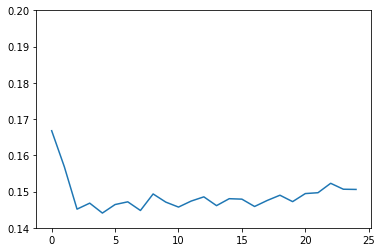

In [54]:
val_loss = np.array( [ x.history['val_loss'] for x in historyList ] )
print(val_loss.shape)
val_loss_avg = np.mean(val_loss, axis = 0)

plt.plot(val_loss_avg)
plt.ylim(0.14, 0.20)
#plt.title('Removed %d features from time dataset' % (numRemove_static_list[i_static]))
plt.show

In [ ]:
## optimize the number of epochs for each quantile
inputSize = 7
normalizeTarget = False

quantileList = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
num_epoch = 10

NUM_CELLS = 512
NUM_DAYS_OUT = 14

num_repeat = 2
modelList = []
historyList512 = []


# normalization - static
data_static_zscore, data_static_mean, data_static_std = normalizeData(dataList_static_PCA)

# normalization - time
data_time_zscore, data_time_mean, data_time_std = normalizeData(dataList_time)

# for static dataset
trainingData_static, testingData_static = dataPrep_LSTM_fromNP_static(data_static_zscore, data_time_zscore, inputSize, 14, 1, 14)

# for timeseries dataset
trainingData_time, trainingAns_time, testingData_time, testingAns_time = dataPrep_LSTM_fromNP_time(data_time_zscore, 'deaths', inputSize, 14, 1, 14, columns_time_selected_reorder)

# unnormalize the targets
if not normalizeTarget:
    trainingAns_time, testingAns_time = unnormalizeTarget(trainingAns_time, testingAns_time, data_time_mean, data_time_std, columns_time_selected_reorder, 'deaths')



    
# train the model
for rep in range(num_repeat):
    model = condLSTM(NUM_CELLS, NUM_DAYS_OUT)
    model.call([trainingData_time, trainingData_static])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    history = model.fit(x=[trainingData_time, trainingData_static], y=trainingAns_time,
              validation_data=([testingData_time, testingData_static], testingAns_time),
              epochs=num_epoch, shuffle=True, batch_size=64)
    modelList.append(model)
    historyList512.append(history)
            